In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import voigt_profile
from scipy.optimize import curve_fit

In [63]:
def voigt(x, a, s, g):
    return a * voigt_profile(x, s, g)


def bivoigt(x, a1, s1, g1, a2, s2, g2):
    return a1 * voigt_profile(x, s1, g1)/ voigt_profile(0, s1, g1) + a2 * voigt_profile(x - 228.2, s2, g2)/ voigt_profile(0, s2, g2)


def bivoigt_equal(x, a1, a2, s):
    return a1 * voigt_profile(x, s, 11.0) / voigt_profile(0, s, 11.0) + a2 * voigt_profile(x - 228.2, s, 11.0) /  voigt_profile(0, s, 11.0)


def preprocess(x, y, left=0.2, right=0.2):
    plt.figure(figsize=(12, 4))
    plt.plot(x, y, color="blue")

    cut1 = round(len(x) * left)
    cut2 = round(len(x) * right)
    temp_x, temp_y = x[cut1:-cut2], y[cut1:-cut2]

    plt.plot(temp_x, temp_y, color="red")
    plt.tight_layout()
    return temp_x, temp_y


def process(x, y, left=0.2, right=0.2, mid=0.5):
    plt.figure(figsize=(14, 4))
    
    plt.subplot(221)
    plt.plot(x, y, color="blue")

    cut1 = round(len(x) * left)
    cut2 = round(len(x) * right)
    k1, b1 = np.polyfit(x[:cut1], y[:cut1], deg=1)
    k2, b2 = np.polyfit(x[-cut2:], y[-cut2:], deg=1)

    plt.subplot(222)
    plt.plot(x, y, color="blue")
    plt.plot(x, k1 * x + b1, color="green")
    plt.plot(x, k2 * x + b2, color="red")

    temp_x, temp_y = x[:], y[:]

    plt.subplot(223)
    intercept = len(x[x < (b2 - b1) / (k1 - k2)])
    temp_y[:intercept] -= (k1 * x[:intercept] + b1)
    temp_y[intercept:] -= (k2 * x[intercept:] + b2)
    plt.plot(temp_x[:round(len(temp_x) * mid)], temp_y[:round(len(temp_x) * mid)], color="red")
    plt.plot(temp_x[round(len(temp_x) * mid):], temp_y[round(len(temp_x) * mid):], color="blue")

    

    plt.subplot(224)
    
    
    idx1, idx2 = np.argmax(temp_y[:round(len(temp_x) * mid)]), np.argmax(temp_y[round(len(temp_x) * mid):]) + round(len(temp_x) * mid)
    m1, m2 = temp_x[idx1], temp_x[idx2]

    temp_x = (temp_x - m1) * 228.2 / (m2 - m1)
    temp_y *= 5.7 / 20

    plt.scatter(temp_x, temp_y, color="red", s=10, alpha=0.2)

    kernel_size = 500
    kernel = np.ones(kernel_size) / kernel_size
    temp_y = np.convolve(temp_y, kernel, mode='same')

    plt.figure(figsize=(8, 6))
    plt.plot(temp_x, temp_y, color="blue")
    plt.xlabel("MHz")
    plt.ylabel("nW")

    plt.tight_layout()

    return temp_x, temp_y, idx1, idx2


def fit(x, y, idx1, idx2):
    p1, p2 = curve_fit(voigt, x[:idx1], y[:idx1])[0], curve_fit(voigt, x[idx2:] - 228.2, y[idx2:])[0]
    a1, s1, g1, a2, s2, g2 = *p1, *p2
    s = (s1 + s2) / 2
    g = (g1 + g2) / 2

    params = curve_fit(bivoigt_equal, x, y, [a1, a2, s])[0]

    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.scatter(x, y, alpha=0.1, s=1, color="black")
    plt.plot(x, voigt(x, *p1) + voigt(x - 228.2, *p2), color="blue", label="sum")
    plt.xlabel("MHz")
    plt.ylabel("nW")
    plt.legend()

    plt.subplot(122)
    plt.scatter(x, y, alpha=0.1, s=1, color="black")
    plt.plot(x, bivoigt_equal(x, *params), color="red", label="equal")
    plt.legend()
    plt.xlabel("MHz")
    plt.ylabel("nW")

    plt.tight_layout()

    return params, [a1, a2, s1, s2, g1, g2]

def fit2(x, y, idx1, idx2):
    p1, p2 = curve_fit(voigt, x[:idx1], y[:idx1])[0], curve_fit(voigt, x[idx2:] - 228.2, y[idx2:])[0]
    a1, s1, g1, a2, s2, g2 = *p1, *p2
    s = (s1 + s2) / 2
    g = (g1 + g2) / 2

    params = curve_fit(bivoigt_equal, x, y, [a1, a2, s])[0]

    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.scatter(x, y, alpha=0.1, s=1, color="black")
    plt.plot(x, voigt(x, *p1) + voigt(x - 228.2, *p2), color="blue", label="sum")
    plt.xlabel("MHz")
    plt.ylabel("nW")
    plt.legend()

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.1, s=1, color="black")
    plt.plot(x, bivoigt_equal(x, *params), color="red")
    plt.legend()
    plt.xlabel("МГц", fontsize=14)
    plt.ylabel("нВт", fontsize=14)
    plt.title("Сумма профилей Фойгта после обработки", fontsize=14)

    plt.tight_layout()

    return params, [a1, a2, s1, s2, g1, g2]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[2.17575616e-04 1.08189070e-04 4.19003692e+01]


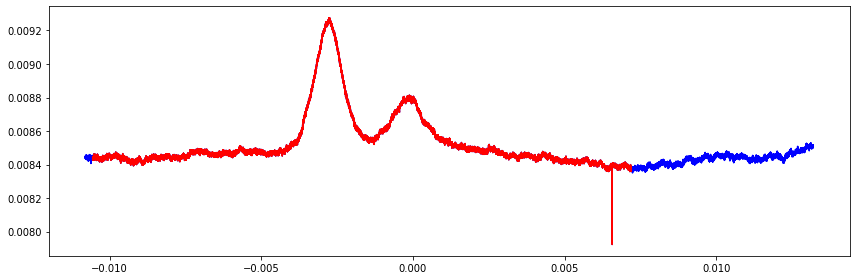

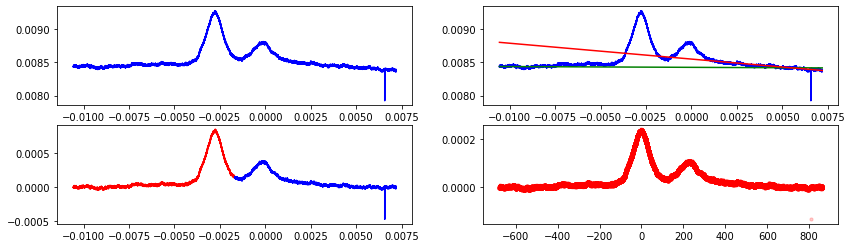

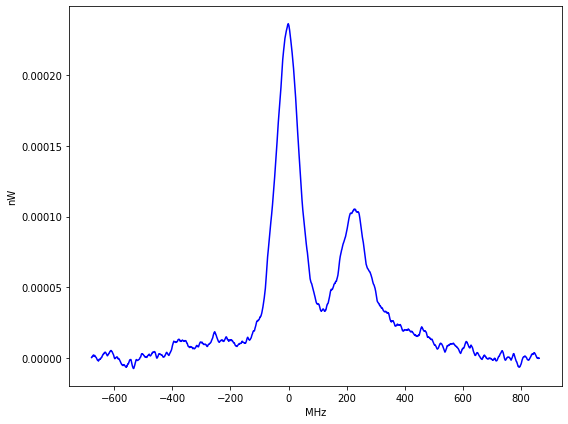

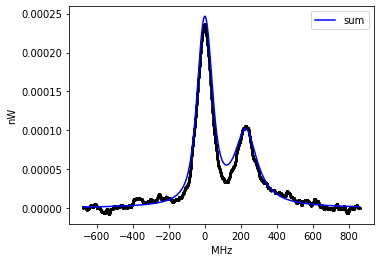

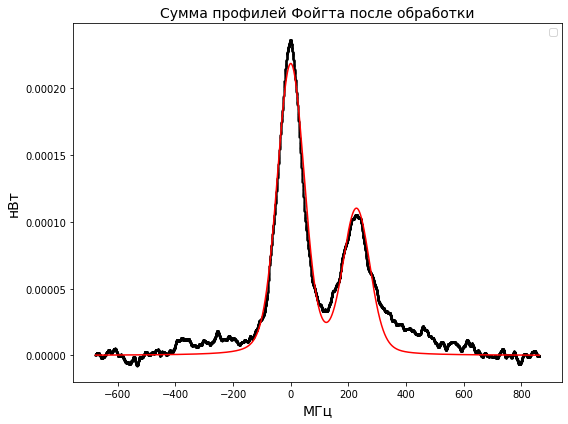

In [64]:
data = pd.read_csv("data/new_data/MM{}.CSV".format(71))

x, y = np.array(data.iloc[::, 0]), np.array(data.iloc[::, 3])

x, y = preprocess(x, y, 0.01, 0.25)

x, y, idx1, idx2 = process(x, y, 0.15, 0.1, 0.5)

params71 = fit2(x, y, idx1, idx2)[0]

print(params71)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[3.42388608e-04 1.52713330e-04 4.03583787e+01]


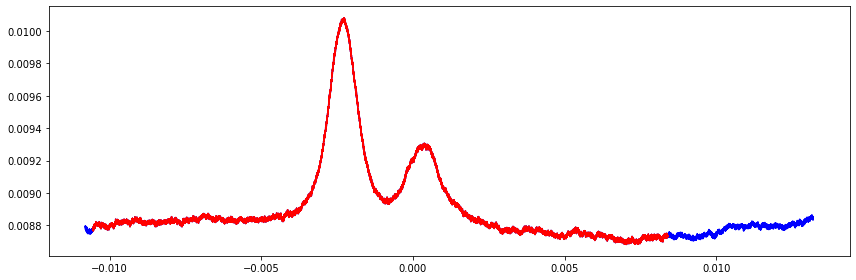

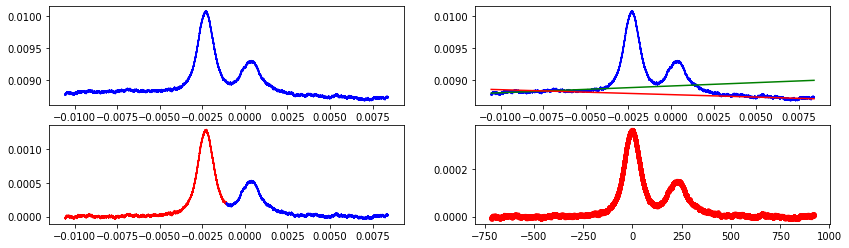

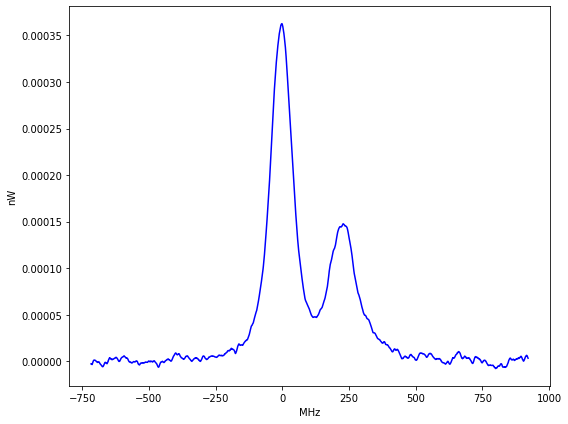

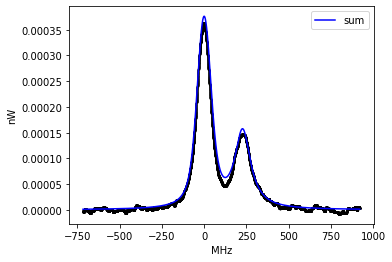

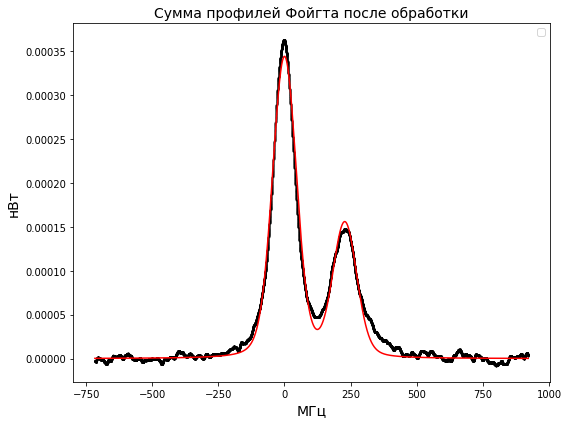

In [65]:
data = pd.read_csv("data/new_data/MM{}.CSV".format(72))

x, y = np.array(data.iloc[::, 0]), np.array(data.iloc[::, 3])

x, y = preprocess(x, y, 0.01, 0.2)

x, y, idx1, idx2 = process(x, y, 0.15, 0.15, 0.5)

params72 = fit2(x, y, idx1, idx2)[0]

print(params72)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[4.49726332e-04 1.91299140e-04 3.88703151e+01]


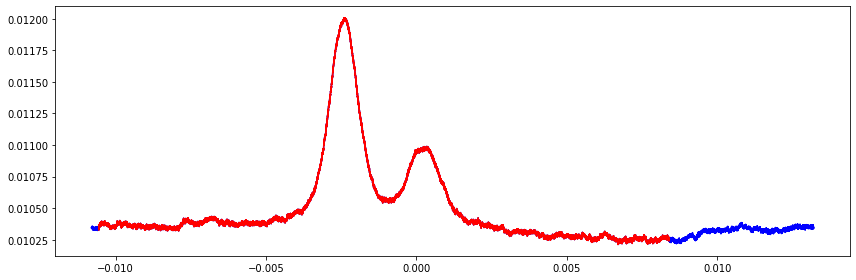

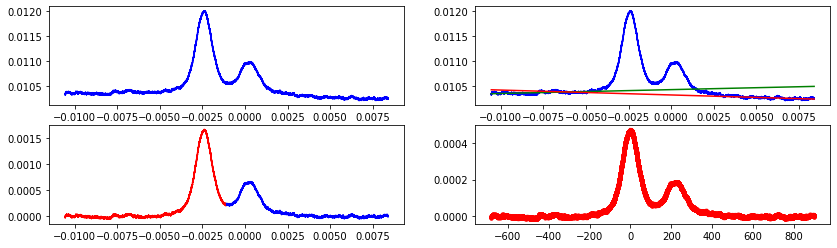

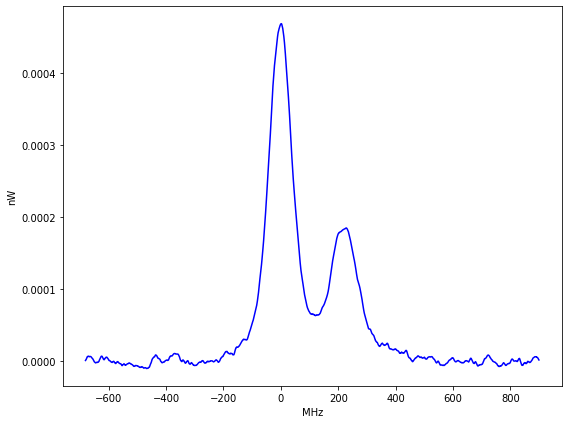

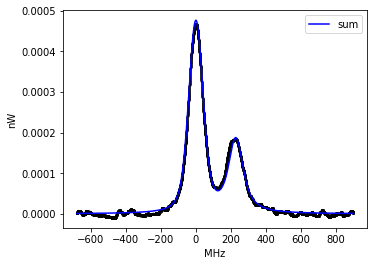

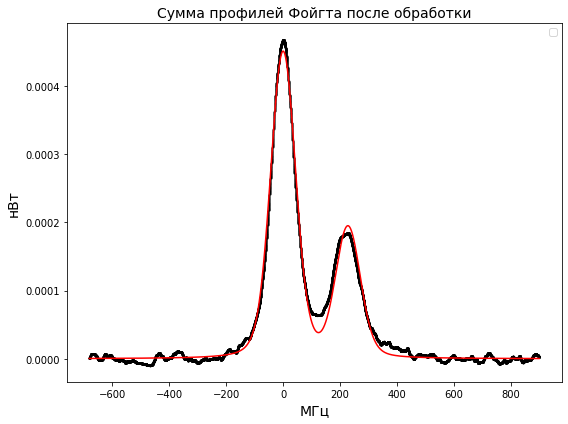

In [66]:
data = pd.read_csv("data/new_data/MM{}.CSV".format(73))

x, y = np.array(data.iloc[::, 0]), np.array(data.iloc[::, 3])

x, y = preprocess(x, y, 0.01, 0.2)

x, y, idx1, idx2 = process(x, y, 0.2, 0.2, 0.5)

params73 = fit2(x, y, idx1, idx2)[0]

print(params73)

TypeError: bivoigt_equal() takes 4 positional arguments but 5 were given

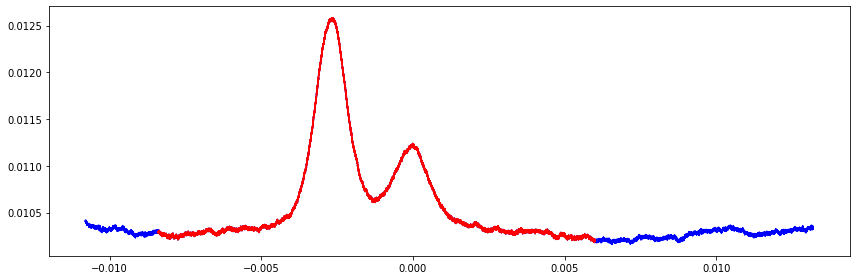

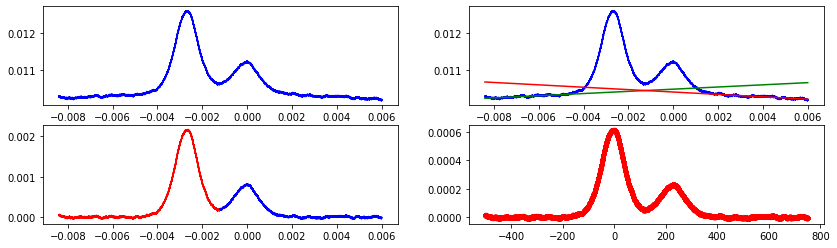

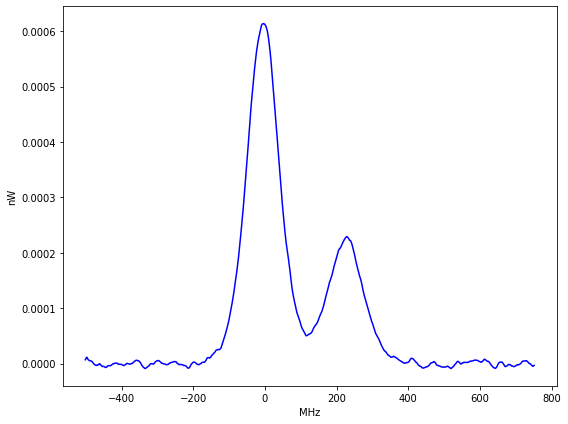

In [61]:
data = pd.read_csv("data/new_data/MM{}.CSV".format(74))

x, y = np.array(data.iloc[::, 0]), np.array(data.iloc[::, 3])

x, y = preprocess(x, y, 0.1, 0.3)

x, y, idx1, idx2 = process(x, y, 0.2, 0.2, 0.5)

params74 = fit2(x, y, idx1, idx2)[0]

print(params74)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[6.71841029e-04 2.65790215e-04 4.43204893e+01]


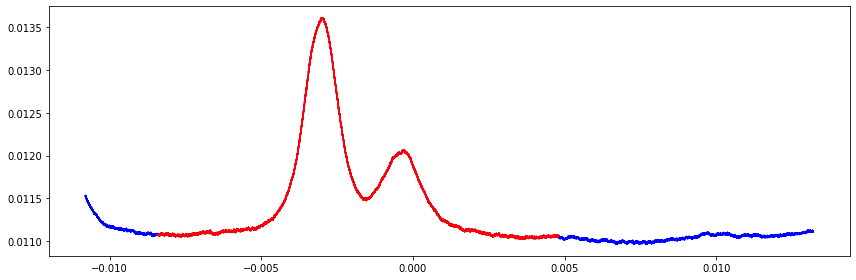

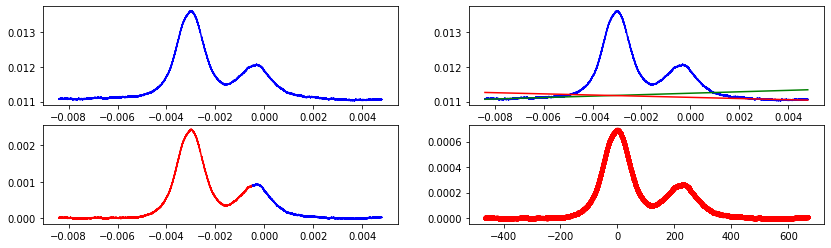

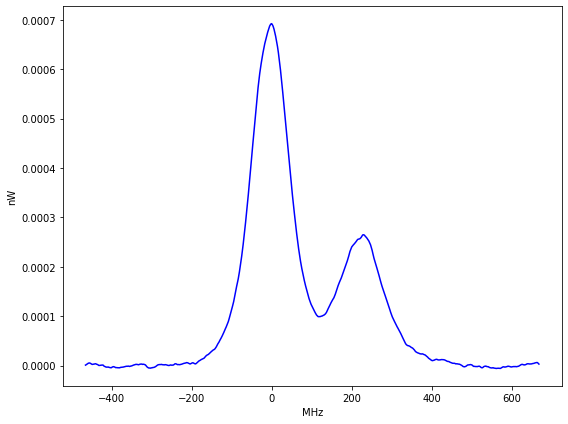

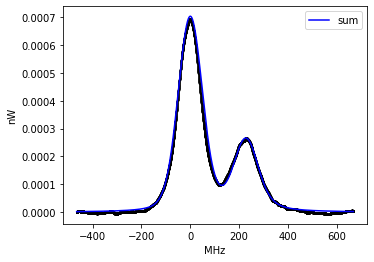

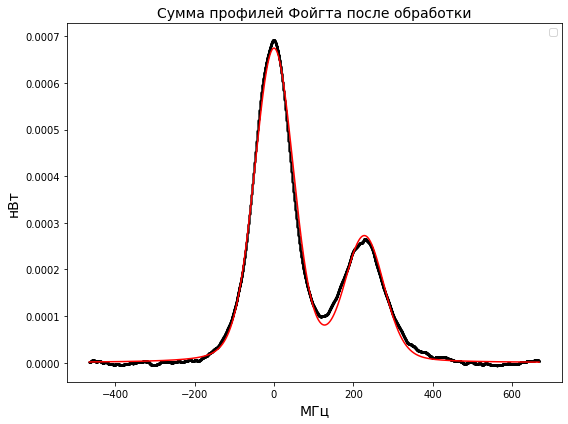

In [24]:
data = pd.read_csv("data/new_data/MM{}.CSV".format(75))

x, y = np.array(data.iloc[::, 0]), np.array(data.iloc[::, 3])

x, y = preprocess(x, y, 0.1, 0.35)

x, y, idx1, idx2 = process(x, y, 0.2, 0.2, 0.6)

params75 = fit2(x, y, idx1, idx2)[0]

print(params75)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

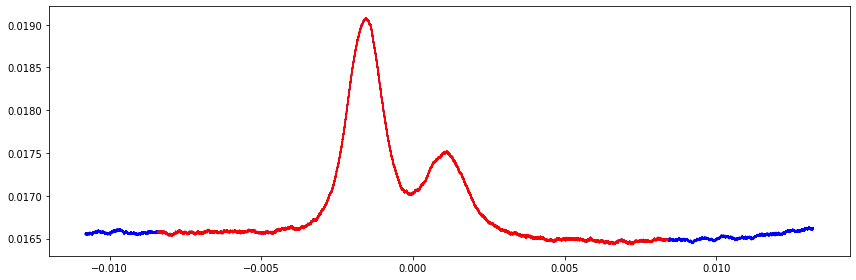

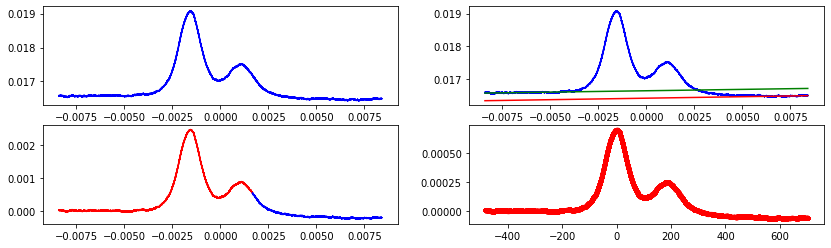

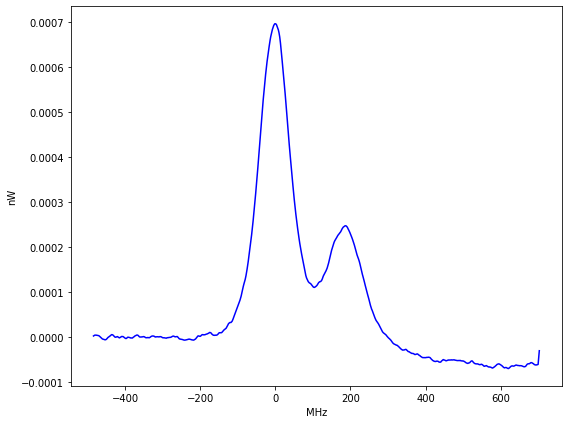

In [45]:
data = pd.read_csv("data/new_data/MM{}.CSV".format(76))

x, y = np.array(data.iloc[::, 0]), np.array(data.iloc[::, 3])

x, y = preprocess(x, y, 0.1, 0.2)

x, y, idx1, idx2 = process(x, y, 0.15, 0.15, 0.6)

params76 = fit2(x, y, idx1, idx2)[0]

print(params76)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[5.36149142e-04 2.33026106e-04 4.81888600e+01]


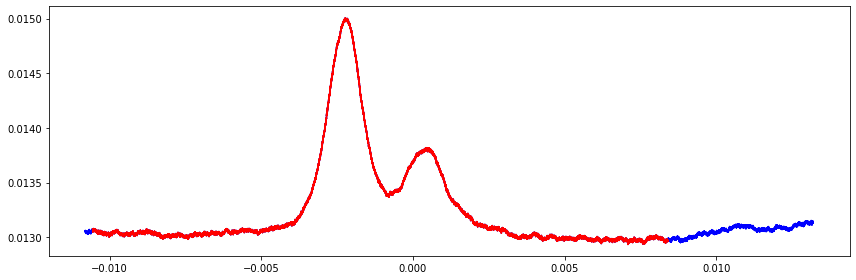

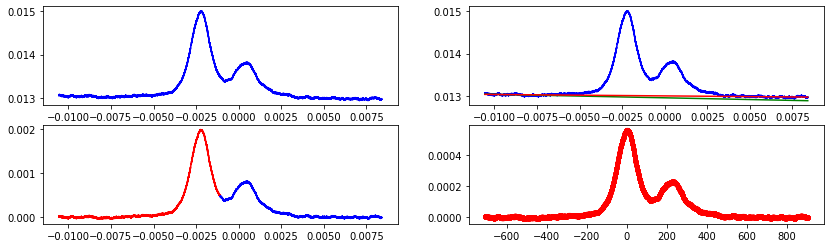

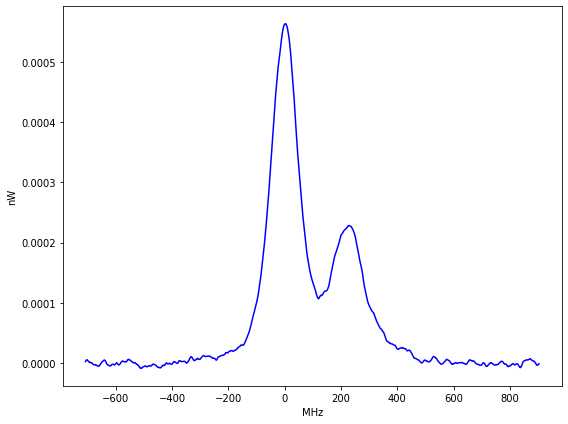

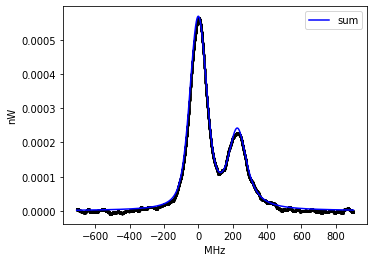

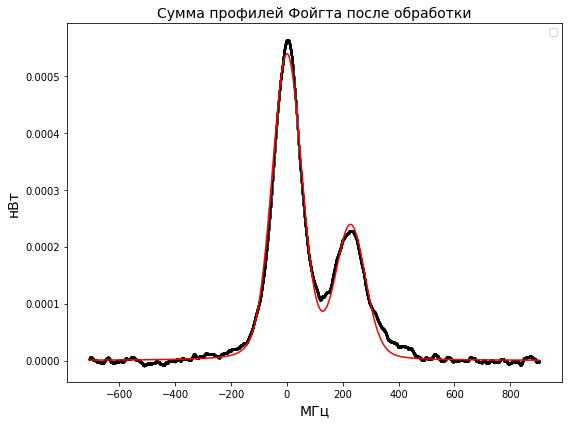

In [44]:
data = pd.read_csv("data/new_data/MM{}.CSV".format(77))

x, y = np.array(data.iloc[::, 0]), np.array(data.iloc[::, 3])

x, y = preprocess(x, y, 0.01, 0.2)

x, y, idx1, idx2 = process(x, y, 0.2, 0.2, 0.5)

params77 = fit2(x, y, idx1, idx2)[0]

print(params77)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[2.91515771e-04 1.30756824e-04 4.72799003e+01]


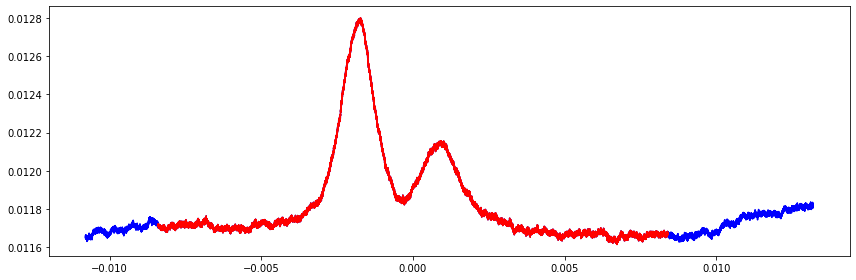

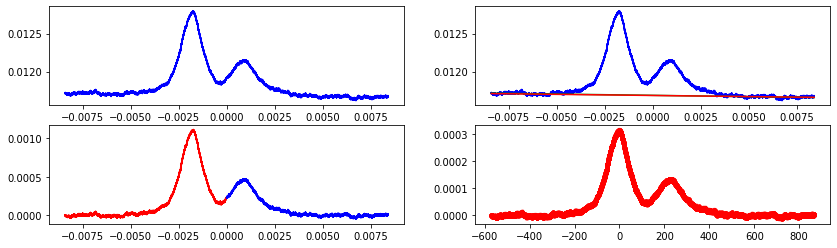

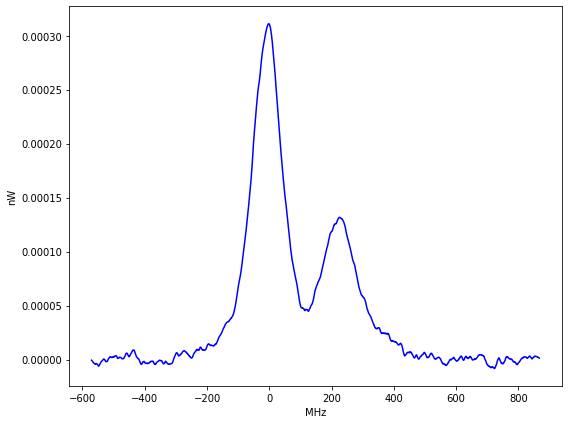

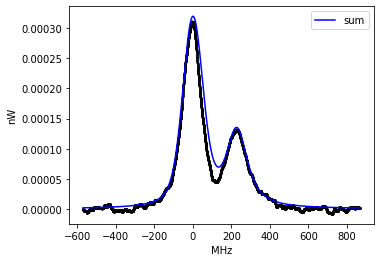

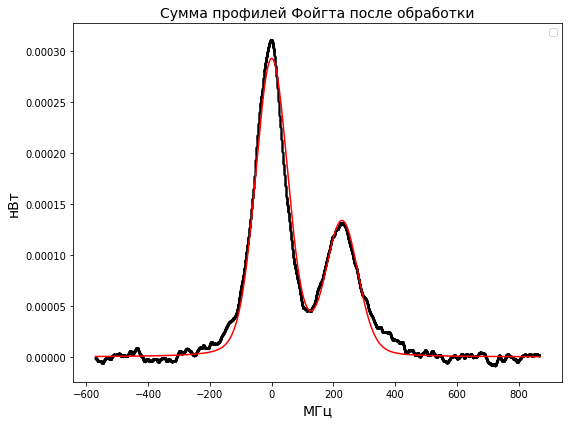

In [42]:
data = pd.read_csv("data/new_data/MM{}.CSV".format(78))

x, y = np.array(data.iloc[::, 0]), np.array(data.iloc[::, 3])

x, y = preprocess(x, y, 0.1, 0.2)

x, y, idx1, idx2 = process(x, y, 0.2, 0.2, 0.5)

params78 = fit2(x, y, idx1, idx2)[0]

print(params78)